<a href="https://colab.research.google.com/github/uhdang/mlim_group_3_final_assignment/blob/main/master_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master Copy

## IDEAS

#### Feature Ideas
- Exercise #7 - slide 5
    - own-product moving widow purchase frequencies
    - customer embedding (matrix-factorization)

## Setup

In [1]:
import numpy as np
import pandas as pd

from random import randrange

## Load Data

In [2]:
if 'google.colab' in str(get_ipython()):       from google.colab import drive
  drive.mount('/content/drive')
  b_df = pd.read_parquet("/content/drive/MyDrive/My Drive/baskets.parquet")
  c_df = pd.read_parquet("/content/drive/MyDrive/My Drive/coupons.parquet")
  ci_df = pd.read_parquet("/content/drive/MyDrive/My Drive/coupon_index.parquet")
else:
  file_path = "./data/"

  baskets_pq = "baskets.parquet"
  coupons_pq = "coupons.parquet"
  coupon_index_pq = "coupon_index.parquet"

  b_df = pd.read_parquet(file_path + baskets_pq)
  c_df = pd.read_parquet(file_path + coupons_pq)
  ci_df = pd.read_parquet(file_path + coupon_index_pq)

  print(f"baskets_df: {b_df.shape}")
  print(f"coupons_df: {c_df.shape}")
  print(f"coupon_index_df: {ci_df.shape}")

baskets_df: (68841598, 4)
coupons_df: (45000000, 4)
coupon_index_df: (10000, 3)


## Data Preprocessing

### A. Number of Target Shoppers

In [3]:
num_of_shoppers = 100

shoppers = [i for i in range(num_of_shoppers)]
print(f"shoppers.shape: {shoppers}")

shoppers.shape: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


### B. Generate Master Dataframe

In [ ]:
def get_original_prices(basket_df):
    return basket_df.groupby(["product"])["price"].agg(["max"]).reset_index()

In [ ]:
def gen_complete_week_prod_df_for_shoppers(list_shoppers, orig_df):
    products = np.array(list(range(250)))
    orig_price_list = orig_df["max"].values
    
    weeks = list(range(90))
    
    product_price_pair = np.stack((products, orig_price_list), axis=0).T
    
    prod_in_weeks = []
    for w in weeks:
        for p in product_price_pair:
            prod_in_weeks.append([w, *p])
    
    df_template = pd.DataFrame(data=prod_in_weeks, columns=["week", "product", "orig_price"])
    
    df_master = None;
    
    for idx, shoppers in enumerate(list_shoppers):

        df_local = df_template.copy()
        df_local["shopper"] = shoppers
        
        if idx == 0:
            df_master = df_local
        else:
            # stack it
            df_master = pd.concat([df_master, df_local], axis=0)
    return df_master

In [ ]:
orig_price_tb = get_original_prices(b_df)
df = gen_complete_week_prod_df_for_shoppers(shoppers, orig_price_tb)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (2250000, 4)


,week,product,orig_price,shopper
0,0,0,688,0
1,0,1,560,0
2,0,2,773,0


### C. Target Column added while adding Basket data

In [ ]:
b_df["target"] = 1
df = df.merge(b_df, how="left", on=["week", "shopper", "product"])
df["target"] = df["target"].fillna(0)
print(f"df.shape: {df.shape}")

df.shape: (2250000, 6)


In [ ]:
# df.sample(50)
df.head(2)

,week,product,orig_price,shopper,price,target
0,0,0,688,0,NaN,0.0
1,0,1,560,0,NaN,0.0


### D. Discount_given column added while adding Discout data

In [ ]:
c_df["coupon_given"] = 1
df = df.merge(right=c_df, how="left", on=["week", "shopper", "product"])
df["discount"] = df["discount"].fillna(0)
df["coupon_given"] = df["coupon_given"].fillna(0)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (2250000, 8)


,week,product,orig_price,shopper,price,target,discount,coupon_given
0,0,0,688,0,NaN,0.0,0.0,0.0
1,0,1,560,0,NaN,0.0,0.0,0.0
2,0,2,773,0,NaN,0.0,0.0,0.0


### E. Price with discount

In [ ]:
df["price_w_discount"] = df["orig_price"] - df["discount"]

# price column is no longer necessary so removing it
df = df.drop(columns=["price"])

In [ ]:
# df.head(60)

## Split Data Before Feature Engineering

In [ ]:
# Train: 0 - 88
# Test: 88 - 89
cut_day = 89

# Separate train and test
train = df[df["week"] < cut_day]
test = df[df["week"] >= cut_day]

b_train = b_df[b_df["week"] < cut_day]
b_test = b_df[b_df["week"] >= cut_day]

c_train = c_df[c_df["week"] < cut_day]
c_test = c_df[c_df["week"] >= cut_day]

print(f"Master: {df.shape}, Train: {train.shape}, Test: {test.shape}")

Master: (2250000, 8), Train: (2225000, 8), Test: (25000, 8)


### A. Average Basket Size per Shopper per week

In [ ]:
average_basket_size = b_train.groupby(['shopper', 'week'])["product"].count().groupby('shopper').mean().to_frame('average_basket_size').reset_index()

In [ ]:
# Merge to shoppers on train and test

train = train.merge(average_basket_size, how="left", on="shopper")
test = test.merge(average_basket_size, how="left", on="shopper")

In [ ]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,average_basket_size
0,0,0,688,0,0.0,0.0,0.0,688.0,8.539326
1,0,1,560,0,0.0,0.0,0.0,560.0,8.539326


### B. Average Price per Shopper per Week

In [ ]:
average_price_per_shopper = b_train.groupby(['shopper'])["price"].mean().to_frame('average_price_per_shopper').reset_index()

In [ ]:
# Include it to the shoppers

train = train.merge(average_price_per_shopper, how="left", on="shopper")
test = test.merge(average_price_per_shopper, how="left", on="shopper")

In [ ]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,average_basket_size,average_price_per_shopper
0,0,0,688,0,0.0,0.0,0.0,688.0,8.539326,587.203947
1,0,1,560,0,0.0,0.0,0.0,560.0,8.539326,587.203947


### C. Number of Unique Products purchased per Shopper

In [ ]:
unique_products_per_shopper = b_train.groupby(['shopper'])["product"].nunique()
unique_products_per_shopper_df = unique_products_per_shopper.to_frame("num_unique_products").reset_index()

In [ ]:
# Include it to the shoppers

train = train.merge(num_unique_prods_per_shopper, how="left", on="shopper")
test = test.merge(num_unique_prods_per_shopper, how="left", on="shopper")

In [ ]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,average_basket_size,average_price_per_shopper,num_unique_prods
0,0,0,688,0,0.0,0.0,0.0,688.0,8.539326,587.203947,54
1,0,1,560,0,0.0,0.0,0.0,560.0,8.539326,587.203947,54


### D Total Counts for Product

In [ ]:
total_count_of_product = b_train.groupby(['shopper', 'product'])["product"].count().to_frame('total_count_of_product').reset_index()

In [ ]:
# Merge to train and test
train = train.merge(total_count_of_product, how="left", on=["shopper","product"])
test = test.merge(total_count_of_product, how="left", on=["shopper","product"])

In [ ]:
train["total_count_of_product"] = train["total_count_of_product"].fillna(0)
test["total_count_of_product"] = test["total_count_of_product"].fillna(0)

### G. Weeks Since Prior Order

#### a. train

In [ ]:
# Train set
addkey = train.groupby(['shopper','product'])["target"].apply(lambda x : x.eq(1).shift().fillna(0).cumsum())
train['weeks_since_prior_order'] = train["target"].eq(0).groupby([train['shopper'], train['product'], addkey]).cumcount().add(1)

#### b. test

In [ ]:
# Test set
last_weeks_since_prior_order = train.groupby(['shopper', 'product'])["weeks_since_prior_order"].last() + 1
test = test.merge(last_weeks_since_prior_order, on=['shopper', 'product'])

In [ ]:
train.sample(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,average_basket_size,average_price_per_shopper,num_unique_prods,total_count_of_product,weeks_since_prior_order
1168348,45,98,481,52,0.0,0.0,0.0,481.0,6.078652,573.565619,74,0.0,46
2144112,32,112,727,96,0.0,0.0,0.0,727.0,7.033708,565.047923,80,0.0,33


In [ ]:
test.sample(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,average_basket_size,average_price_per_shopper,num_unique_prods,total_count_of_product,weeks_since_prior_order
12548,89,48,465,50,0.0,0.0,0.0,465.0,9.348315,563.960337,85,0.0,90
20564,89,64,575,82,0.0,0.0,0.0,575.0,7.775281,572.184971,88,0.0,90


### H. Category 

#### f - 1. gensim Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# Caution ! Takes REAALLY Long !!
# TEMPORARY - Since target shopper is limited to 2000, reduce the basket to 2000

# by basket => groupby(["week", "shopper"])

num_shoppers = 5_000

by_basket_str = b_df[b_df["shopper"] < num_shoppers]
by_basket_str["product"] = by_basket_str["product"].astype(str)
by_basket_str = by_basket_str.groupby(["week", "shopper"])["product"].apply(list).reset_index(name="list_prod")

<ipython-input-129-f62795059696>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  by_basket_str["product"] = by_basket_str["product"].astype(str)


In [ ]:
by_basket_str.head()

,week,shopper,list_prod
0,0,0,"[71, 91, 116, 123, 157, 167, 171, 184, 207, 225]"
1,0,1,"[22, 35, 92, 146, 168, 200, 211, 229]"
2,0,2,"[14, 121, 164, 218, 230, 249]"
3,0,3,"[6, 67, 98, 137, 145, 192, 222]"
4,0,4,"[25, 76, 156, 188, 234]"


In [ ]:
# basket list
by_basket = by_basket_str["list_prod"].tolist()

# Create a Word2Vec model
w2v_model = Word2Vec(
    sentences=by_basket,
    min_count=10,
    negative=5,
    sample=0,
    sg=1,
    workers=10,
)

# summarize the loaded model
print(w2v_model)

Word2Vec(vocab=250, size=100, alpha=0.025)


In [ ]:
product_keys = [str(product) for product in range(250)]
product_vectors = w2v_model.wv[product_keys]

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=0).fit(product_vectors)
kmeans.labels_

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22,
       22, 22, 22, 22, 22

In [ ]:
# Generate a product category
products = [product for product in range(250)]
prods_cat_table = pd.DataFrame(data=products, columns=["product"])
prods_cat_table["category"] = kmeans.labels_
prods_cat_table[['product', 'category']] = prods_cat_table[['product', 'category']].astype('category')

In [ ]:
prods_cat_table

,product,category
0,0,12
1,1,12
2,2,12
3,3,12
4,4,12
...,...,...
245,245,8
246,246,8
247,247,8
248,248,8


In [ ]:
train = train.merge(right=prods_cat_table, how="left", on=["product"])
test = test.merge(right=prods_cat_table, how="left", on=["product"])

In [ ]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,average_basket_size,average_price_per_shopper,num_unique_prods,total_count_of_product,weeks_since_prior_order,category
0,0,0,688,0,0.0,0.0,0.0,688.0,8.539326,587.203947,54,0.0,1,12
1,0,1,560,0,0.0,0.0,0.0,560.0,8.539326,587.203947,54,0.0,1,12


### I. Weeks since prior order from the Same Category

#### I - 1. train

In [ ]:
new_test_cat = pd.DataFrame(train.groupby(['shopper','category','week'])['target'].sum().reset_index())
mask = new_test_cat.groupby(['shopper', 'category'])['target'].cumsum().replace(0, False).astype(bool) # Mask starting zeros as NaN
df_out_cat = new_test_cat.assign(last_cat_order = new_test_cat.groupby(['shopper','category', new_test_cat.target.astype(bool).cumsum()]).cumcount().where(mask))
df_out_cat["last_cat_order"][df_out_cat["last_cat_order"].isna()]= 0
df_out_cat = df_out_cat[['shopper', 'category','week','last_cat_order']]
train = train.merge(df_out_cat, on = ['shopper', 'week', 'category'], how = 'left')

<ipython-input-138-2053987e4111>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out_cat["last_cat_order"][df_out_cat["last_cat_order"].isna()]= 0


In [ ]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,average_basket_size,average_price_per_shopper,num_unique_prods,total_count_of_product,weeks_since_prior_order,category,last_cat_order
0,0,0,688,0,0.0,0.0,0.0,688.0,8.539326,587.203947,54,0.0,1,12,0.0
1,0,1,560,0,0.0,0.0,0.0,560.0,8.539326,587.203947,54,0.0,1,12,0.0


#### I - 2. test

In [ ]:
# Test set
last_weeks_since_prior_order_from_same_cat = train.groupby(['shopper', 'product'])["last_cat_order"].last() + 1
test = test.merge(last_weeks_since_prior_order_from_same_cat, on=['shopper', 'product'])

In [ ]:
test.sample(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,average_basket_size,average_price_per_shopper,num_unique_prods,total_count_of_product,weeks_since_prior_order,category,last_cat_order
21056,89,56,761,84,0.0,0.0,0.0,761.0,7.831461,553.753228,65,0.0,90,4,4.0
16682,89,182,656,66,0.0,0.0,0.0,656.0,10.202247,600.808370,94,39.0,2,6,1.0


## Model Declaration and Setup for Predictive Analysis

### A. X_train, X_test, y_train, y_test split

In [ ]:
# Features to drop for X
features_to_drop = ["target", "week"]

X_train = train.drop(columns=features_to_drop)
y_train = train["target"]

X_test = test.drop(columns=features_to_drop)
y_test = test["target"]

In [ ]:
X_train

,product,orig_price,shopper,discount,coupon_given,price_w_discount,average_basket_size,average_price_per_shopper,num_unique_prods,total_count_of_product,weeks_since_prior_order,category,last_cat_order
0,0,688,0,0.0,0.0,688.0,8.539326,587.203947,54,0.0,1,12,0.0
1,1,560,0,0.0,0.0,560.0,8.539326,587.203947,54,0.0,1,12,0.0
2,2,773,0,0.0,0.0,773.0,8.539326,587.203947,54,0.0,1,12,0.0
3,3,722,0,0.0,0.0,722.0,8.539326,587.203947,54,0.0,1,12,0.0
4,4,620,0,0.0,0.0,620.0,8.539326,587.203947,54,8.0,1,12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224995,245,549,99,0.0,0.0,549.0,8.797753,618.717752,76,0.0,89,8,11.0
2224996,246,702,99,0.0,0.0,702.0,8.797753,618.717752,76,41.0,11,8,11.0
2224997,247,670,99,0.0,0.0,670.0,8.797753,618.717752,76,0.0,89,8,11.0
2224998,248,490,99,0.0,0.0,490.0,8.797753,618.717752,76,0.0,89,8,11.0


In [ ]:
y_train

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
2224995    0.0
2224996    0.0
2224997    0.0
2224998    0.0
2224999    0.0
Name: target, Length: 2225000, dtype: float64

### B. Model Declaration

In [ ]:
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

In [ ]:
from collections import Counter

# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]

lgb_clf = LGBMClassifier(
    scale_pos_weight=1 #estimate
    )

In [ ]:
counter

Counter({0.0: 2157059, 1.0: 67941})

In [ ]:
estimate

31.749002811262713

In [ ]:
categorical = X_train.select_dtypes(exclude=np.number).columns.tolist()
for cats in categorical:
  X_train[cats] = X_train[cats].astype('category')
  X_test[cats] = X_test[cats].astype('category')

In [ ]:
y_train

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
2224995    0.0
2224996    0.0
2224997    0.0
2224998    0.0
2224999    0.0
Name: target, Length: 2225000, dtype: float64

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225000 entries, 0 to 2224999
Data columns (total 13 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   product                    category
 1   orig_price                 int64   
 2   shopper                    int64   
 3   discount                   float64 
 4   coupon_given               float64 
 5   price_w_discount           float64 
 6   average_basket_size        float64 
 7   average_price_per_shopper  float64 
 8   num_unique_prods           int64   
 9   total_count_of_product     float64 
 10  weeks_since_prior_order    int64   
 11  category                   category
 12  last_cat_order             float64 
dtypes: category(2), float64(7), int64(4)
memory usage: 210.1 MB


In [ ]:
lgb_clf.fit(X_train, y_train, categorical_feature=categorical)

/Users/jungwoojamesjeong/opt/anaconda3/envs/hu-mlim/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=1, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgb_clf.score(X_train, y_train)

0.9831716853932584

In [ ]:
lgb_clf.score(X_test, y_test)

0.97124

### Evaluation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

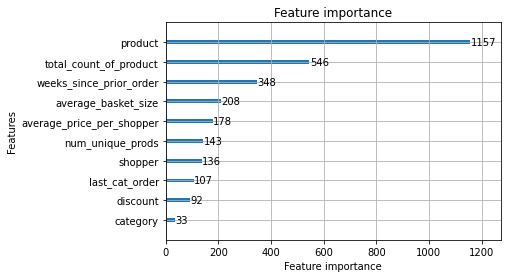

In [ ]:
lgb.plot_importance(lgb_clf, max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

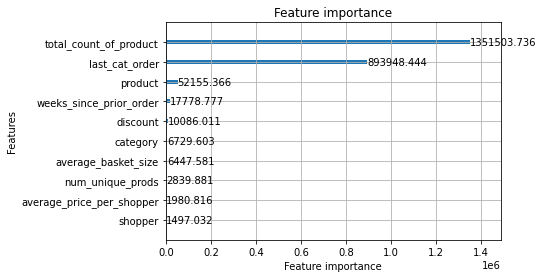

In [ ]:
lgb.plot_importance(lgb_clf, max_num_features=10, importance_type='gain')

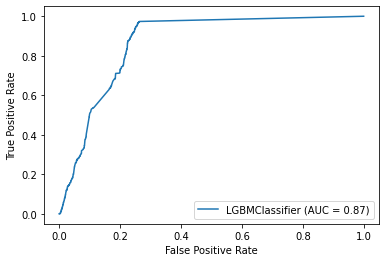

In [ ]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(estimator=lgb_clf, X=X_test, y=y_test)

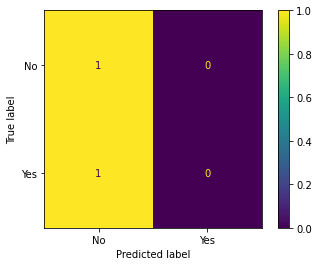

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = lgb_clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(estimator=lgb_clf, X=X_test, y_true=y_test, display_labels=['No', 'Yes'], normalize='true')

In [ ]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   product                    25000 non-null  category
 1   orig_price                 25000 non-null  int64   
 2   shopper                    25000 non-null  int64   
 3   discount                   25000 non-null  float64 
 4   coupon_given               25000 non-null  float64 
 5   price_w_discount           25000 non-null  float64 
 6   average_basket_size        25000 non-null  float64 
 7   average_price_per_shopper  25000 non-null  float64 
 8   num_unique_prods           25000 non-null  int64   
 9   total_count_of_product     25000 non-null  float64 
 10  weeks_since_prior_order    25000 non-null  int64   
 11  category                   25000 non-null  category
 12  last_cat_order             25000 non-null  float64 
dtypes: category(2), float64(7), int

In [ ]:
confusion

array([[24281,     0],
       [  719,     0]])

In [ ]:
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]
TN = confusion[0][0]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# Precision
PPV = TP/(TP+FP)
# False discovery rate -> 1-Precision
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

<ipython-input-166-ffece9289ec4>:17: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP/(TP+FP)
<ipython-input-166-ffece9289ec4>:19: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP/(TP+FP)
